In [1]:
import os
import sys
sys.path.append('..')

import torch
import pickle
import optuna
import numpy as np
import pandas as pd

from uncertain.implicit import logMF, CAMF
from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP
from uncertain.BPR import ABPR, GPR

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt

os.chdir('Behance')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_table('Behance_appreciate_1M', sep=' ', header=None)
    data.columns = ['user', 'item', 'timestamps']
    data = Data(data, implicit=True, users_on_test=1000, distances=False)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)

MovieLens data prepared: 14766 users, 32480 items.
571980 train, 57112 validation and 7956 test interactions.


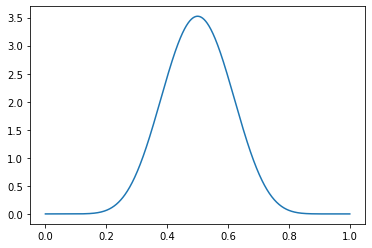

In [4]:
x = np.linspace(start=0, stop=1, num=1000)
plt.plot(x, beta.pdf(x, a=10, b=10))

In [2]:
model = GMF(ML.n_user, ML.n_item, embedding_dim=10, lr=1e-3, n_negative=20)
with open('fitted/gmf_implicit.pth', 'wb') as f:
    this_loss = train(model, ML)
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
test_recommendations(model, ML, max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 58.0 K
1 | item_embeddings | Embedding | 35.3 K
2 | linear          | Linear    | 10    
----------------------------------------------
93.3 K    Trainable params
0         Non-trainable params
93.3 K    Total params
0.373     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'Precision': array([0.02343212, 0.02162302, 0.01952676, 0.01839249, 0.01864232,
        0.01843556, 0.01789406, 0.01776792, 0.01776553, 0.0173501 ]),
 'Recall': array([0.00585803, 0.01081151, 0.01464507, 0.01839249, 0.02330289,
        0.02765334, 0.03131461, 0.03553584, 0.03997243, 0.04337526]),
 'NDCG': array([0.02343212, 0.05504138, 0.08131469, 0.10749953, 0.13673404,
        0.1609969 , 0.18362483, 0.20597636, 0.22651625, 0.24608054]),
 'Diversity': array([0.21790282, 0.2117014 , 0.21922925, 0.22653228, 0.23087451,
        0.23456668, 0.23879377, 0.24276299, 0.24576573]),
 'Novelty': array([0.19849842, 0.18592686, 0.18732536, 0.1889286 , 0.19179559,
        0.19445689, 0.19600517, 0.19799796, 0.20019124, 0.20192182])}

In [10]:
model = MLP(ML.n_user, ML.n_item, embedding_dim=10, lr=1e-3, n_negative=20)
with open('fitted/mlp_implicit.pth', 'wb') as f:
    this_loss = train(model, ML)
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
test_recommendations(model, ML, max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 58.0 K
1 | item_embeddings | Embedding | 35.3 K
2 | linear0         | Linear    | 200   
3 | linear1         | Linear    | 50    
4 | linear2         | Linear    | 5     
----------------------------------------------
93.6 K    Trainable params
0         Non-trainable params
93.6 K    Total params
0.374     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'Precision': array([0.02343212, 0.02162302, 0.01952676, 0.01826327, 0.01847002,
        0.01829198, 0.01782022, 0.01778946, 0.01772724, 0.01736733]),
 'Recall': array([0.00585803, 0.01081151, 0.01464507, 0.01826327, 0.02308753,
        0.02743797, 0.03118539, 0.03557891, 0.03988629, 0.04341833]),
 'NDCG': array([0.02343212, 0.05504138, 0.08131469, 0.10698264, 0.13642198,
        0.16035149, 0.18392239, 0.20624149, 0.22673104, 0.24469634]),
 'Diversity': array([0.21781472, 0.21158753, 0.219047  , 0.22632408, 0.23066823,
        0.23432892, 0.2385655 , 0.24242479, 0.24535393]),
 'Novelty': array([0.19849842, 0.18658139, 0.18777106, 0.18881145, 0.19171581,
        0.19411437, 0.19624128, 0.19803375, 0.20002713, 0.20218819])}

In [ ]:
best_loss = 1000
for wd in [1e-6]:
    model = CAMF(data.n_user, data.n_item, embedding_dim=10, lr=0.001, weight_decay=wd, n_negative=5)
    this_loss = train(model, data, path='checkpoints', name='test')
    if this_loss < best_loss:
        best_loss = this_loss
        with open('fitted/CAMF.pth', 'wb') as f:
            pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 147 K 
1 | item_embeddings | Embedding | 324 K 
2 | linear          | Linear    | 20    
3 | activation      | Softplus  | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.890     Total estimated model params size (MB)
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/vcoscrato/Documents/RecSys/MF/tests/Behance/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


In [5]:
test_recommendations(model, ML, max_k=10)

{'Precision': array([0.02343212, 0.02136458, 0.01992878, 0.018694  , 0.01798759,
        0.01780381, 0.01811559, 0.01813405, 0.01770809, 0.01743625]),
 'Recall': array([0.00585803, 0.01068229, 0.01494659, 0.018694  , 0.02248449,
        0.02670572, 0.03170227, 0.03626809, 0.03984321, 0.04359063]),
 'NDCG': array([0.02343212, 0.05479757, 0.08443824, 0.11133145, 0.13665765,
        0.16119588, 0.18568255, 0.20891139, 0.22838941, 0.24962102]),
 'Diversity': array([0.22269655, 0.22610643, 0.23361432, 0.23973911, 0.24368635,
        0.24687816, 0.24966339, 0.25243559, 0.25503443]),
 'Novelty': array([0.19721618, 0.18530525, 0.19081333, 0.19435603, 0.19652098,
        0.1987931 , 0.20137701, 0.20390979, 0.20550375, 0.20689251]),
 'Uncertainty': array([0.09002491, 0.10286289, 0.10596303, 0.10762468, 0.10875646,
        0.10982297, 0.11106896, 0.11222216, 0.11311057, 0.11402168,
        0.11473786, 0.11540794, 0.11575837, 0.11646367, 0.11693976,
        0.11743632, 0.11757031, 0.11785043, 0.11

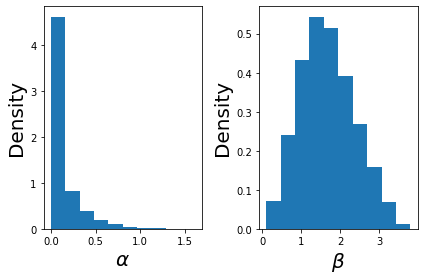

In [6]:
users = torch.randint(0, model.n_user, (10000,))
items = torch.randint(0, model.n_item, (10000,))
with torch.no_grad():
    params = model.forward(users, items)
f, ax = plt.subplots(ncols=2)
ax[0].hist(params[:, 0].numpy(), density=True)
ax[1].hist(params[:, 1].numpy(), density=True)
ax[0].set_xlabel(r'$\alpha$', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[1].set_xlabel(r'$\beta$', fontsize=20)
ax[1].set_ylabel('Density', fontsize=20)
f.tight_layout()

In [7]:
model.linear.weight

Parameter containing:
tensor([[ 2.3060,  2.7541,  2.3166,  2.8394,  2.3763,  2.3870,  2.5084, -0.3101,
          2.3726,  2.7666],
        [-0.0456, -0.6832, -0.1406, -0.8429, -0.1559, -0.2029, -0.3971,  2.2352,
         -0.1421, -0.6837]], requires_grad=True)

In [10]:
model.recommend(2)

,scores,uncertainties
18,0.655697,0.120636
87,0.458901,0.155661
91,0.442144,0.152568
155,0.418528,0.148210
330,0.405414,0.151102
20,0.388035,0.150505
137,0.381735,0.140457
2,0.375897,0.154454
23,0.374568,0.152024
223,0.369051,0.152685
